In [1]:
!pip install openai==0.28

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import List, Dict
import random
import openai
from tqdm import tqdm
import time
import re
import nltk
from nltk.corpus import stopwords

In [3]:
openai.api_key = 'sk-proj-SpgAtKK85bltZIAS9I8uT3BlbkFJZRgj9N8EaGAkpuXlA8p8'

In [4]:
class User:
    def __init__(self, username: str, interests: Dict[str, float]):
        self.username = username
        self.interests = interests
        self.liked_tweets = []

    def update_interests(self, tweet, adjustment_factor):
        for category, tweet_score in tweet.interest_scores.items():
            if category in self.interests:
                new_score = self.interests[category] + (tweet_score * adjustment_factor)
                self.interests[category] = max(0, min(1, new_score))
            else:
                self.interests[category] = tweet_score * adjustment_factor

In [5]:
class Tweet:
    def __init__(self, text: str):
        self.text = text
        self.interest_scores = self.generate_interest_scores()
        self.likes = 0

    def generate_interest_scores(self):
        prompt = f"""
        Analyze the following tweet and provide interest scores for these categories:
        technology, sports, politics, entertainment, food, health, finance, science, travel, education.

        Tweet: "{self.text}"

        Provide the scores as a JSON object where each category has a score between 0 and 1,
        representing the relevance of the tweet to that category. For example:
        {{"technology": 0.8, "sports": 0.2, ...}}
        """

        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that analyzes tweets and provides interest scores."},
                    {"role": "user", "content": prompt}
                ]
            )

            json_string = response.choices[0].message['content'].strip()
            return json.loads(json_string)
        except Exception as e:
            print(f"Error generating interest scores: {e}")
            return {}

    def like(self, user):
        self.likes += 1
        user.liked_tweets.append(self)
        user.update_interests(self, 0.02)

    def unlike(self, user):
        self.likes -= 1
        user.liked_tweets.remove(self)
        user.update_interests(self, -0.01)

In [6]:
# Load tweet data
df = pd.read_csv('dataset.csv')
df.head()

,gender,text,tweet_id
0,male,Robbie E Responds To Critics After Win Against...,6.587300e+17
1,male,ÛÏIt felt like they were my friends and I was...,6.587300e+17
2,male,i absolutely adore when louis starts the songs...,6.587300e+17
3,male,Hi @JordanSpieth - Looking at the url - do you...,6.587300e+17
4,female,Watching Neighbours on Sky+ catching up with t...,6.587300e+17


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)

    return tweet.strip()

In [9]:
df['tweets'] = df['text'].apply(clean_tweet)

In [10]:
print(df[['text', 'tweets']])

                                                    text  \
0      Robbie E Responds To Critics After Win Against...   
1      ÛÏIt felt like they were my friends and I was...   
2      i absolutely adore when louis starts the songs...   
3      Hi @JordanSpieth - Looking at the url - do you...   
4      Watching Neighbours on Sky+ catching up with t...   
...                                                  ...   
20045  @lookupondeath ...Fine, and I'll drink tea too...   
20046  Greg Hardy you a good player and all but don't...   
20047  You can miss people and still never want to se...   
20048  @bitemyapp i had noticed your tendency to pee ...   
20049  I think for my APUSH creative project I'm goin...   

                                                  tweets  
0            robbie e responds critics win eddie edwards  
1                         felt like friends living story  
2      absolutely adore louis starts songs hits hard ...  
3      hi looking url use dont typically se

In [11]:
tweets = []
for _, row in tqdm(df.head(100).iterrows(), total=100, desc="Processing tweets"):
    tweets.append(Tweet(row['tweets']))
    time.sleep(1)

Processing tweets: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


In [12]:
# sample user
user = User("sample_user", {
    "technology": 0.7,
    "sports": 0.2,
    "politics": 0.2,
    "entertainment": 0.7,
    "food": 0.2,
    "health": 0.2,
    "finance": 0.2,
    "science": 0.2,
    "travel": 0.7,
    "education": 0.2
})

In [13]:
# Function to rank tweets for a user
def rank_tweets(user: User, tweets: List[Tweet]) -> List[Tweet]:
    scored_tweets = []
    for tweet in tweets:
        score = sum(user.interests.get(k, 0) * v for k, v in tweet.interest_scores.items())
        scored_tweets.append((tweet, score))
    return [t for t, _ in sorted(scored_tweets, key=lambda x: x[1], reverse=True)]

In [14]:
# Demonstrate tweet ranking
ranked_tweets = rank_tweets(user, tweets)
print("Top 30 ranked tweets for the user:")
for i, tweet in enumerate(ranked_tweets[:30]):
    print(f"{i+1}. {tweet.text[:50]}...")

Top 30 ranked tweets for the user:
1. gala bingo clubs bought uks largest high street bi...
2. gala bingo clubs bought uks largest high street bi...
3. gala bingo clubs bought uks largest high street bi...
4. genie app guessed thinking katniss everdeens daugh...
5. reimagining process...
6. video james bond spectre world premiere months bui...
7. amazon celebrates new vinyl store unveiling day vi...
8. mtg deals x rankupmagic seventh one prioen secret ...
9. triggered email killer conversion app...
10. time would great could fill attached survey could ...
11. join creative group team see latest opening ny...
12. gala bingo clubs bought uks largest high street bi...
13. ditto im still learning favourites retweet stuff l...
14. opposed pump like hi hope like jumps spread feet a...
15. see theres way im going resist shattered empire bu...
16. mean like mainstream new media supposed feed fact ...
17. hi looking url use dont typically see advanced use...
18. went wrong nandos found eventual

In [18]:
# K-means clustering
def get_tweet_vectors(tweets):
    return np.array([list(t.interest_scores.values()) for t in tweets])

tweet_vectors = get_tweet_vectors(tweets)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(tweet_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


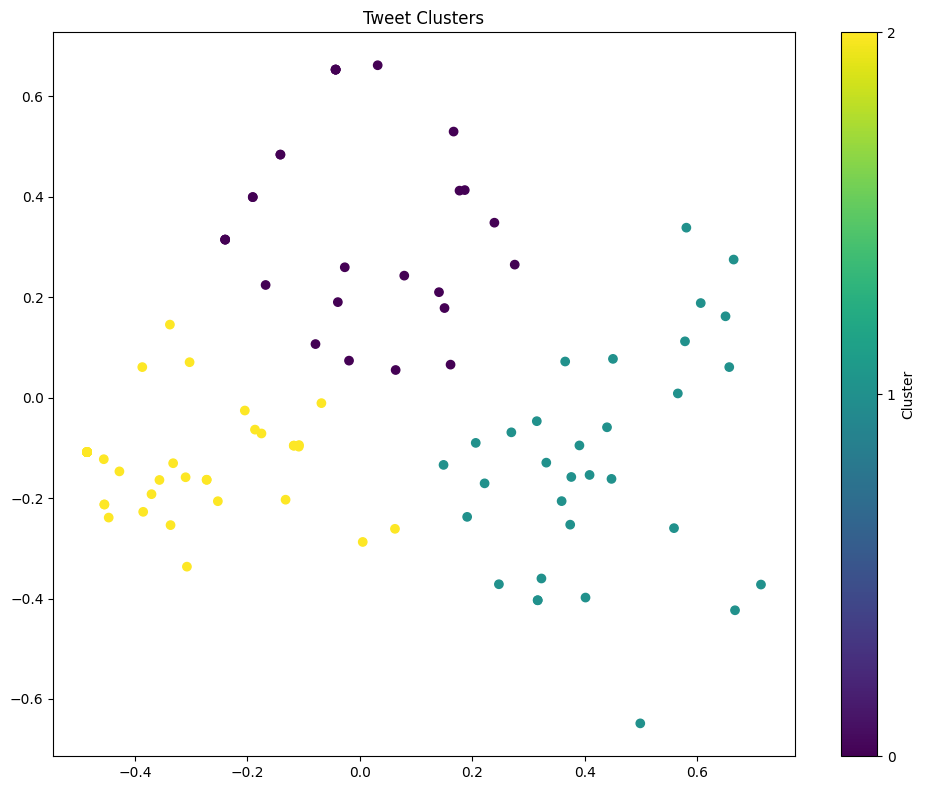

In [20]:
# 2. Tweet Clusters
plt.figure(figsize=(10, 8))
pca = PCA(n_components=2)
tweet_vectors_2d = pca.fit_transform(tweet_vectors)
plt.scatter(tweet_vectors_2d[:, 0], tweet_vectors_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Tweet Clusters")
plt.colorbar(ticks=range(5), label='Cluster')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
<ipython-input-21-b2f7284dd4fd>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.g

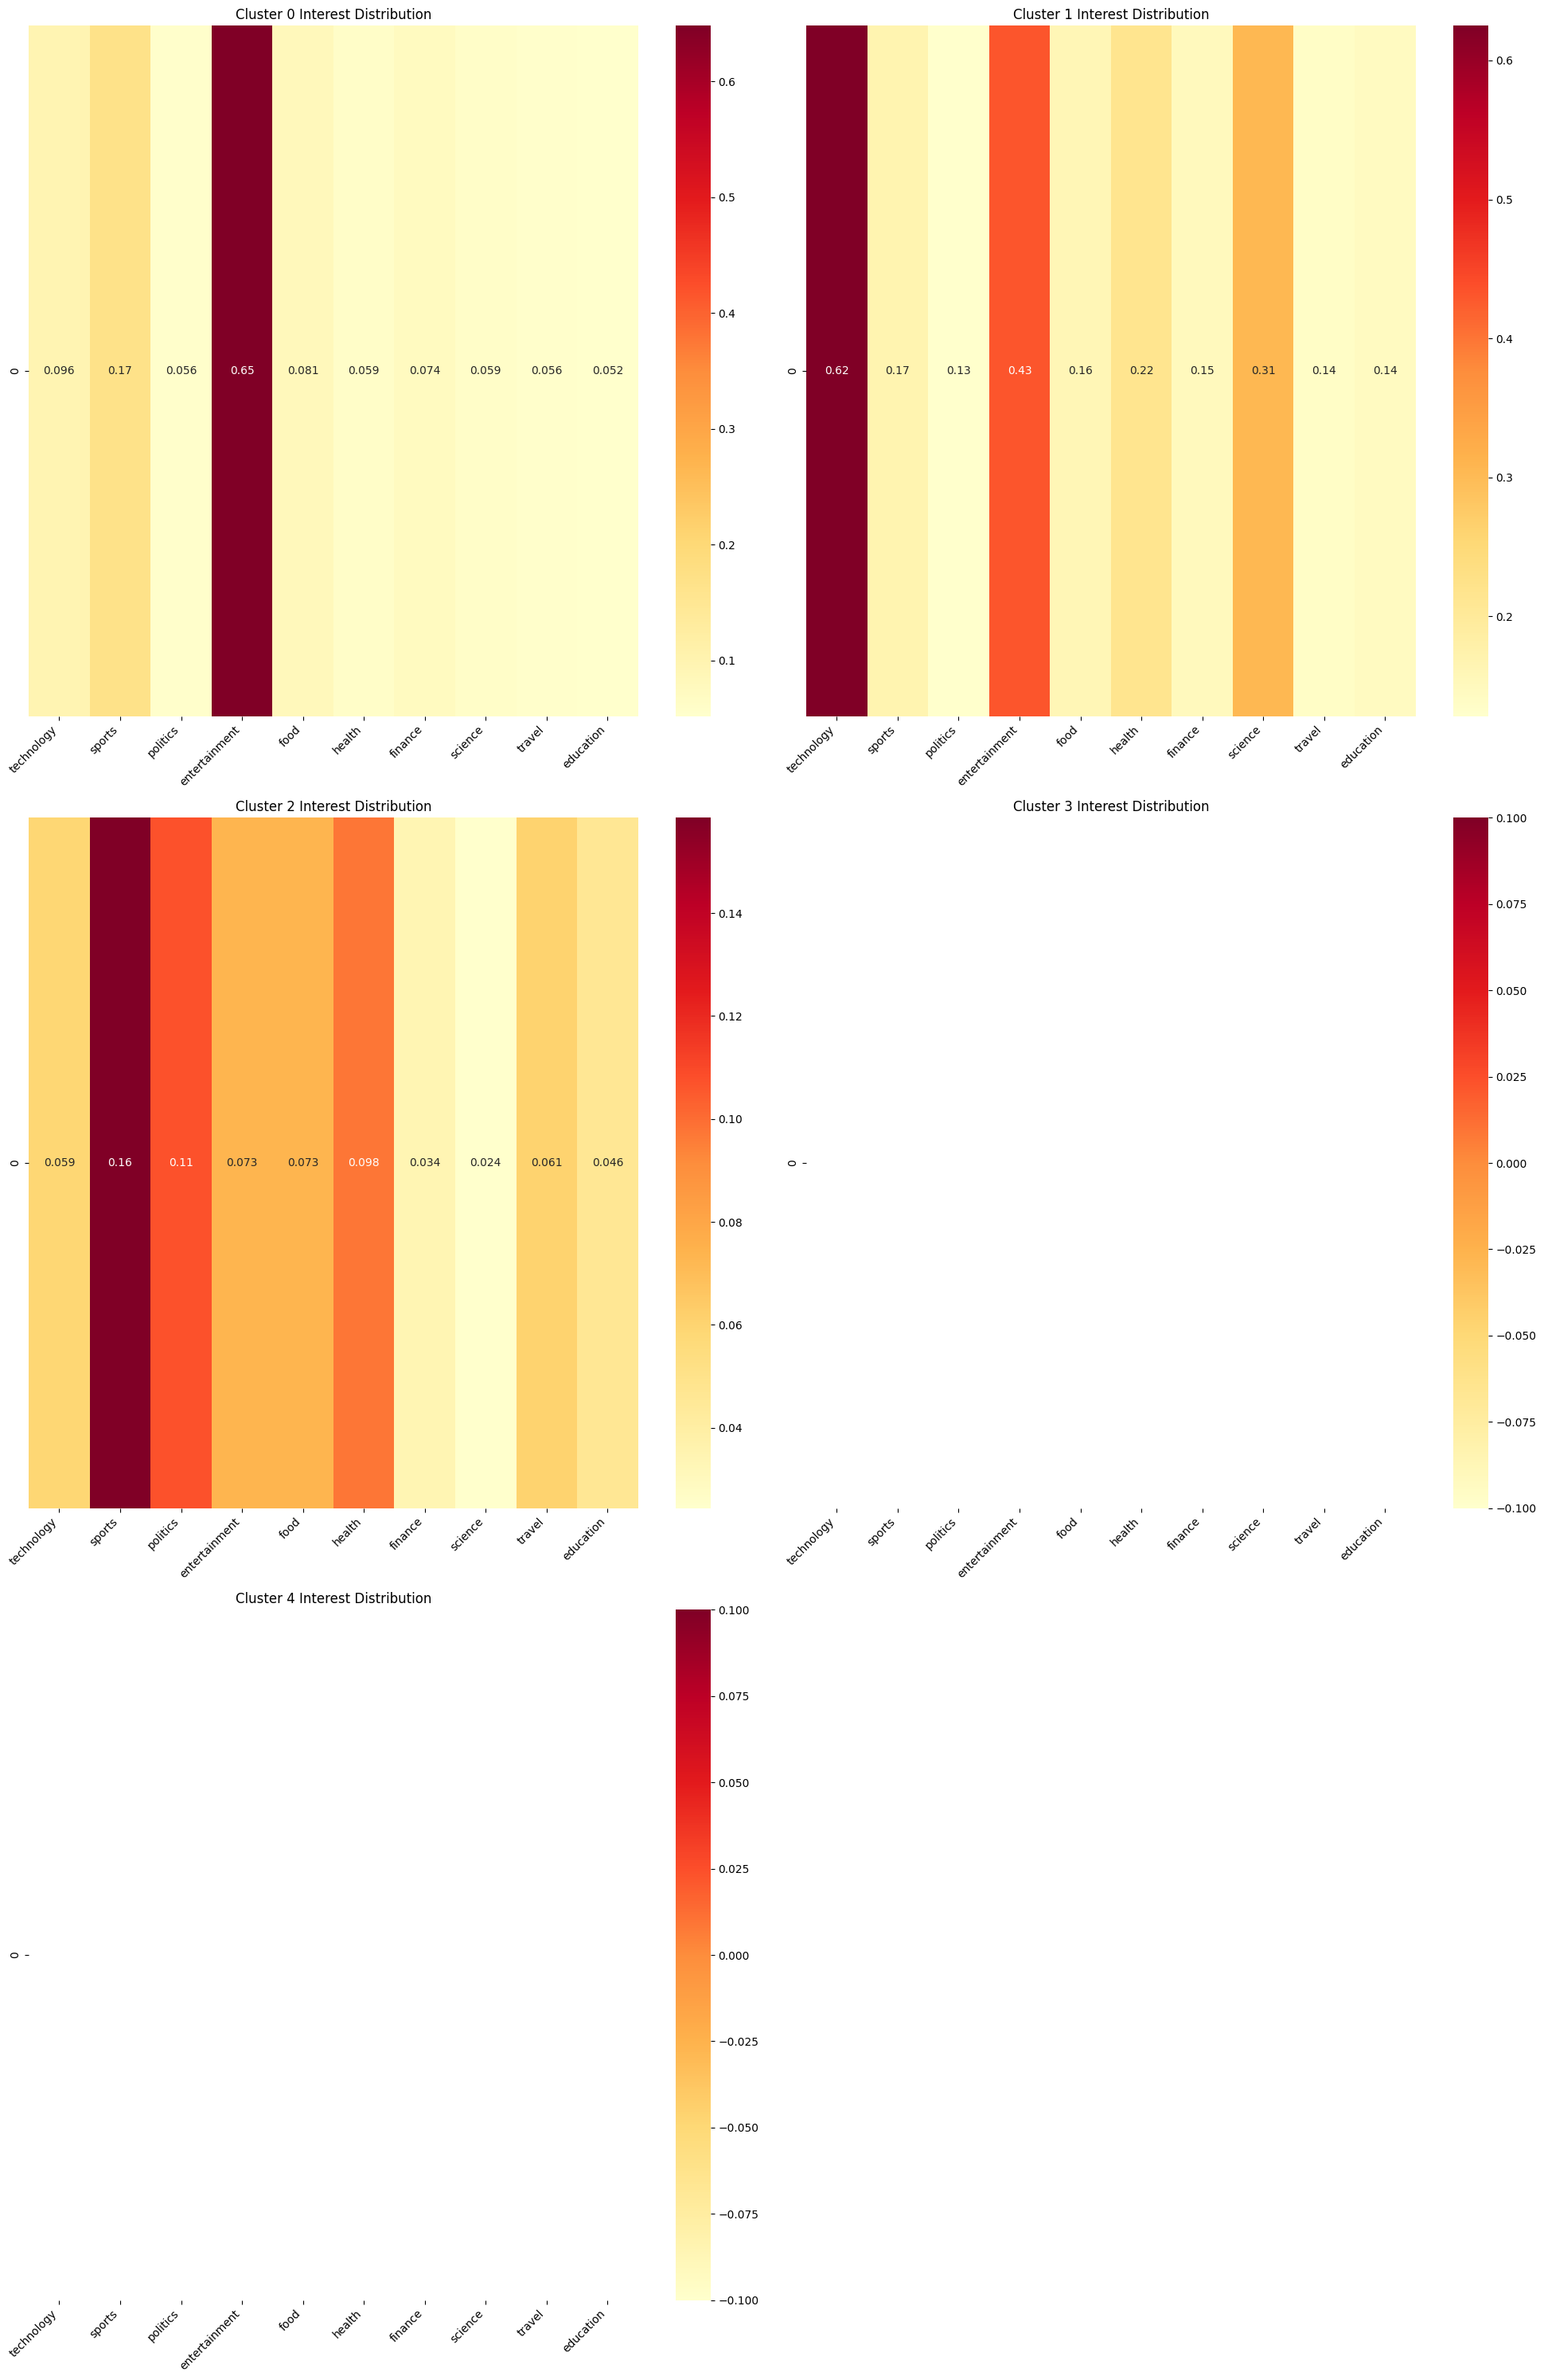

In [21]:
cluster_interests = {}
for i in range(5):
    cluster_tweets = [t for t, l in zip(tweets, cluster_labels) if l == i]
    cluster_interests[i] = {k: np.mean([t.interest_scores[k] for t in cluster_tweets]) for k in user.interests}

fig, axes = plt.subplots(3, 2, figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        sns.heatmap(pd.DataFrame([cluster_interests[i]]), ax=ax, cmap='YlOrRd', annot=True)
        ax.set_title(f"Cluster {i} Interest Distribution")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

In [23]:
initial_interests = user.interests.copy()

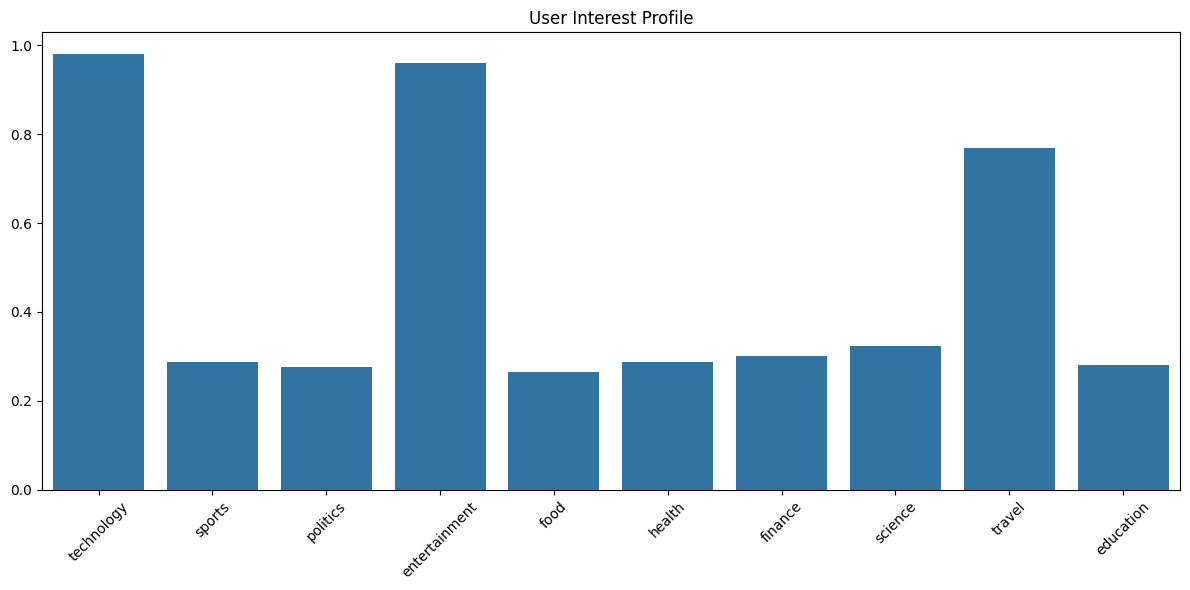

In [25]:
# 1. User Interest Profile
plt.figure(figsize=(12, 6))
sns.barplot(x=list(user.interests.keys()), y=list(user.interests.values()))
plt.title("User Interest Profile")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Simulate user liking tweets
print("\nUser liking tweets:")
for tweet in ranked_tweets[:10]:
    tweet.like(user)
    print(f"Liked: {tweet.text[:50]}...")
    print("Updated user interests:", user.interests)


User liking tweets:
Liked: gala bingo clubs bought uks largest high street bi...
Updated user interests: {'technology': 0.8520000000000001, 'sports': 0.25200000000000006, 'politics': 0.24400000000000005, 'entertainment': 0.8440000000000001, 'food': 0.23600000000000004, 'health': 0.24800000000000005, 'finance': 0.26000000000000006, 'science': 0.26800000000000007, 'travel': 0.74, 'education': 0.24400000000000005}
Liked: gala bingo clubs bought uks largest high street bi...
Updated user interests: {'technology': 0.8640000000000001, 'sports': 0.25800000000000006, 'politics': 0.24800000000000005, 'entertainment': 0.8600000000000001, 'food': 0.24000000000000005, 'health': 0.25400000000000006, 'finance': 0.26800000000000007, 'science': 0.2720000000000001, 'travel': 0.744, 'education': 0.24800000000000005}
Liked: gala bingo clubs bought uks largest high street bi...
Updated user interests: {'technology': 0.8760000000000001, 'sports': 0.26200000000000007, 'politics': 0.25400000000000006, 'ente

<ipython-input-26-1587305f0b3f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-26-1587305f0b3f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


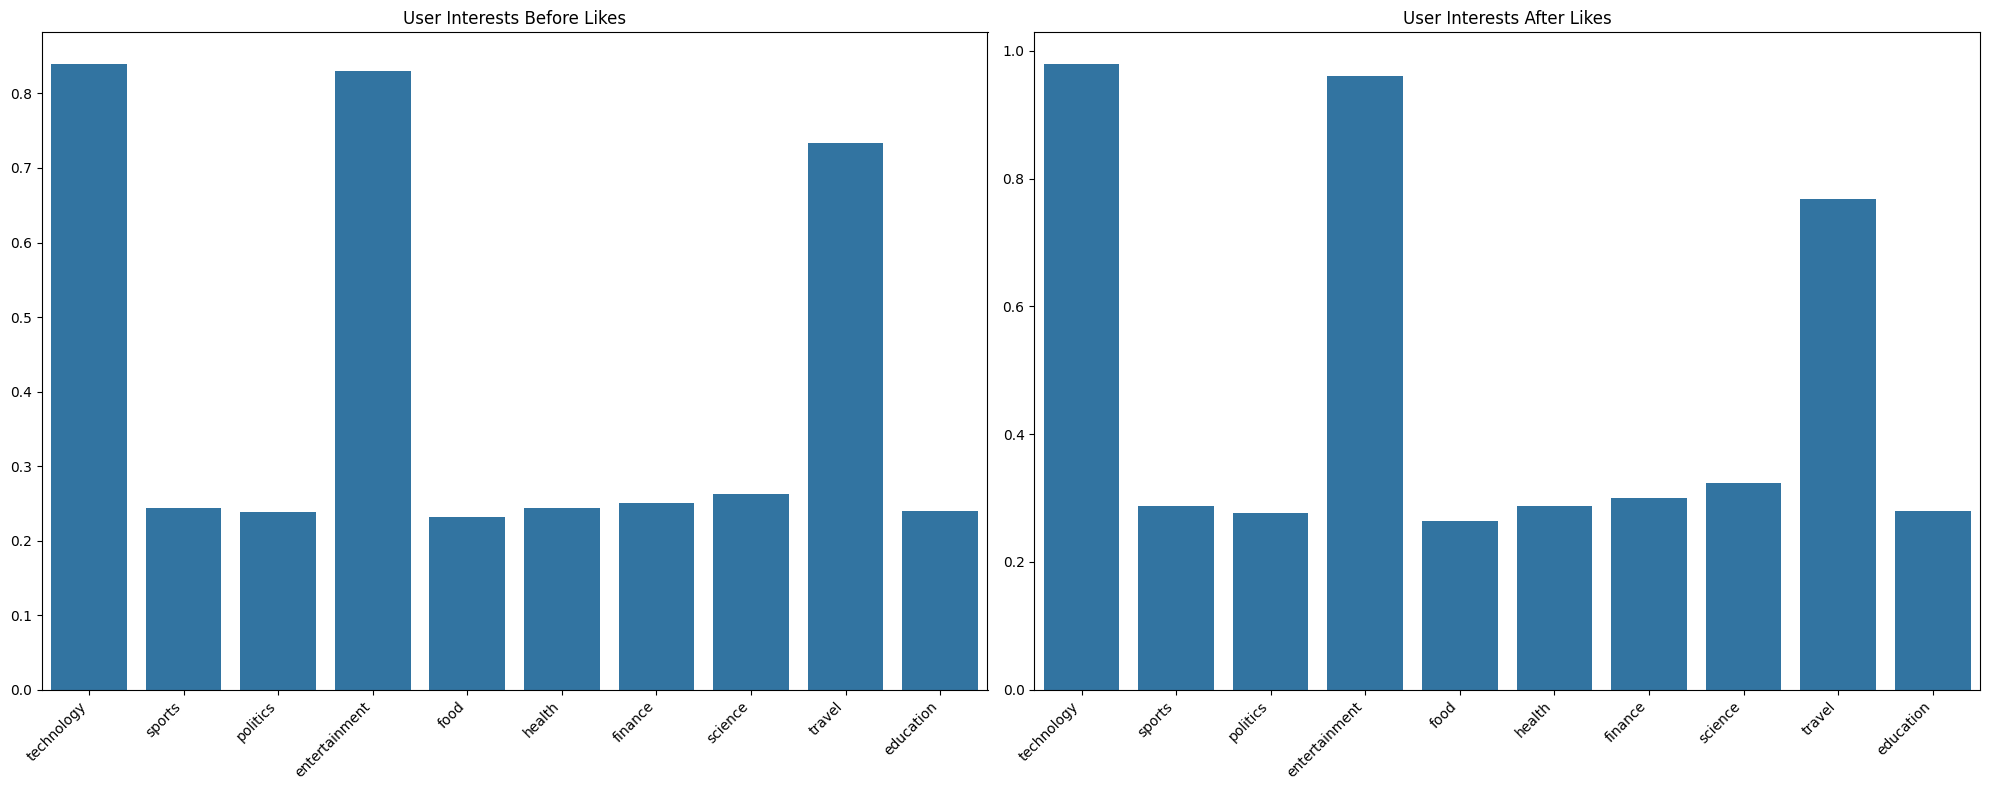

In [26]:
# 4. User Interest Change After Likes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x=list(initial_interests.keys()), y=list(initial_interests.values()), ax=ax1)
ax1.set_title("User Interests Before Likes")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.barplot(x=list(user.interests.keys()), y=list(user.interests.values()), ax=ax2)
ax2.set_title("User Interests After Likes")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

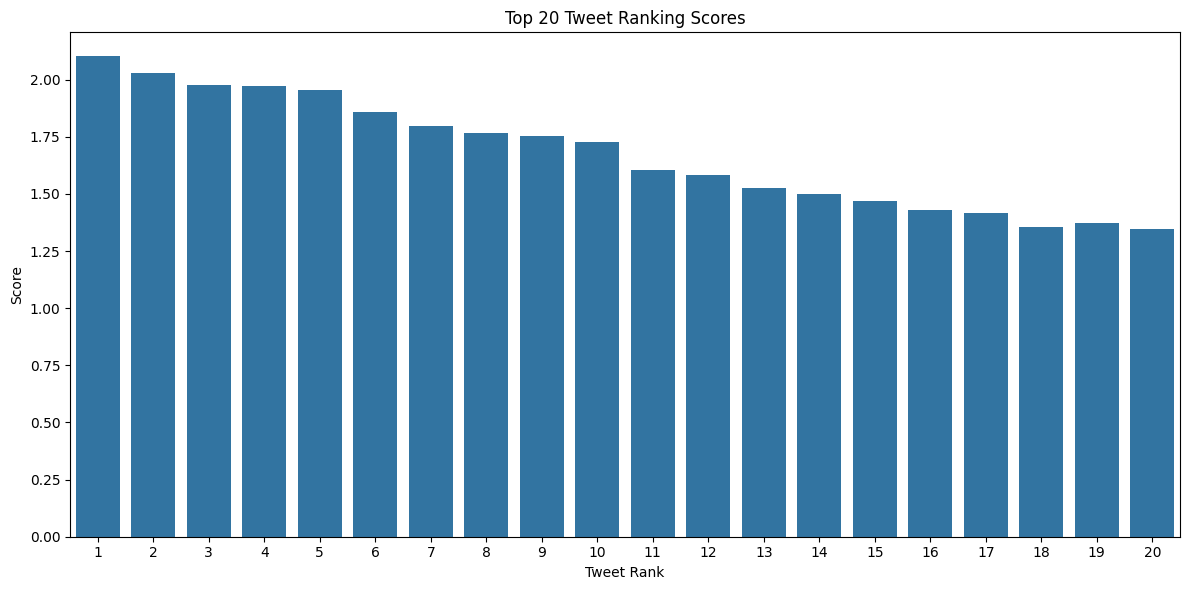

In [27]:
# 5. Tweet Ranking Scores
top_20_scores = [sum(user.interests.get(k, 0) * v for k, v in t.interest_scores.items()) for t in ranked_tweets[:20]]
plt.figure(figsize=(12, 6))
sns.barplot(x=range(1, 21), y=top_20_scores)
plt.title("Top 20 Tweet Ranking Scores")
plt.xlabel("Tweet Rank")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

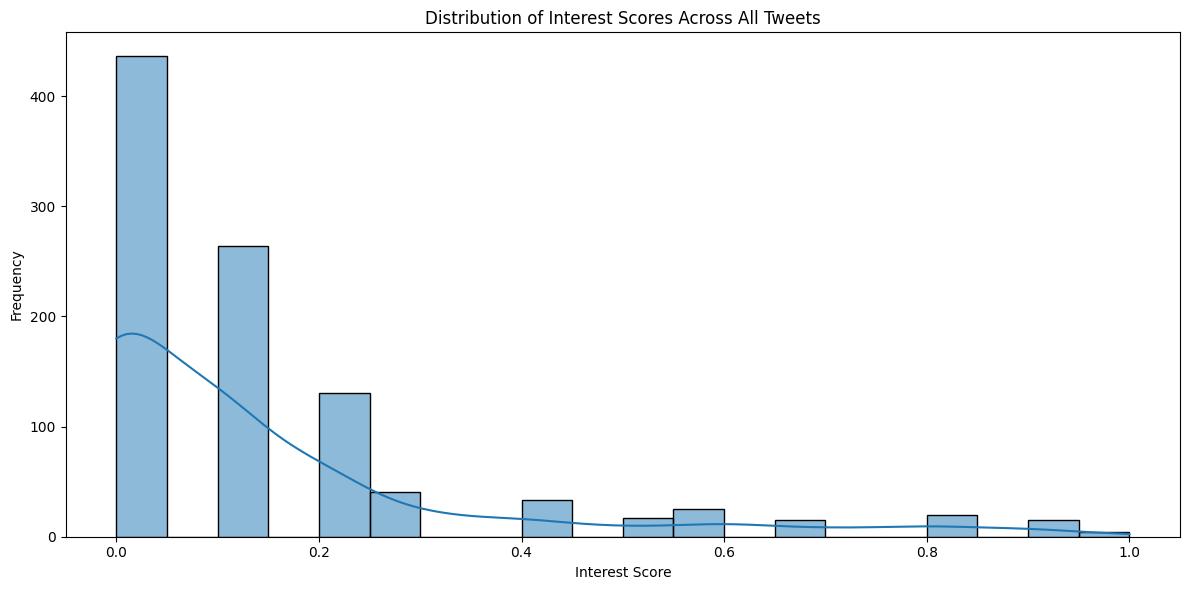

In [28]:
# 6. Interest Score Distribution
all_scores = [score for tweet in tweets for score in tweet.interest_scores.values()]
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.title("Distribution of Interest Scores Across All Tweets")
plt.xlabel("Interest Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

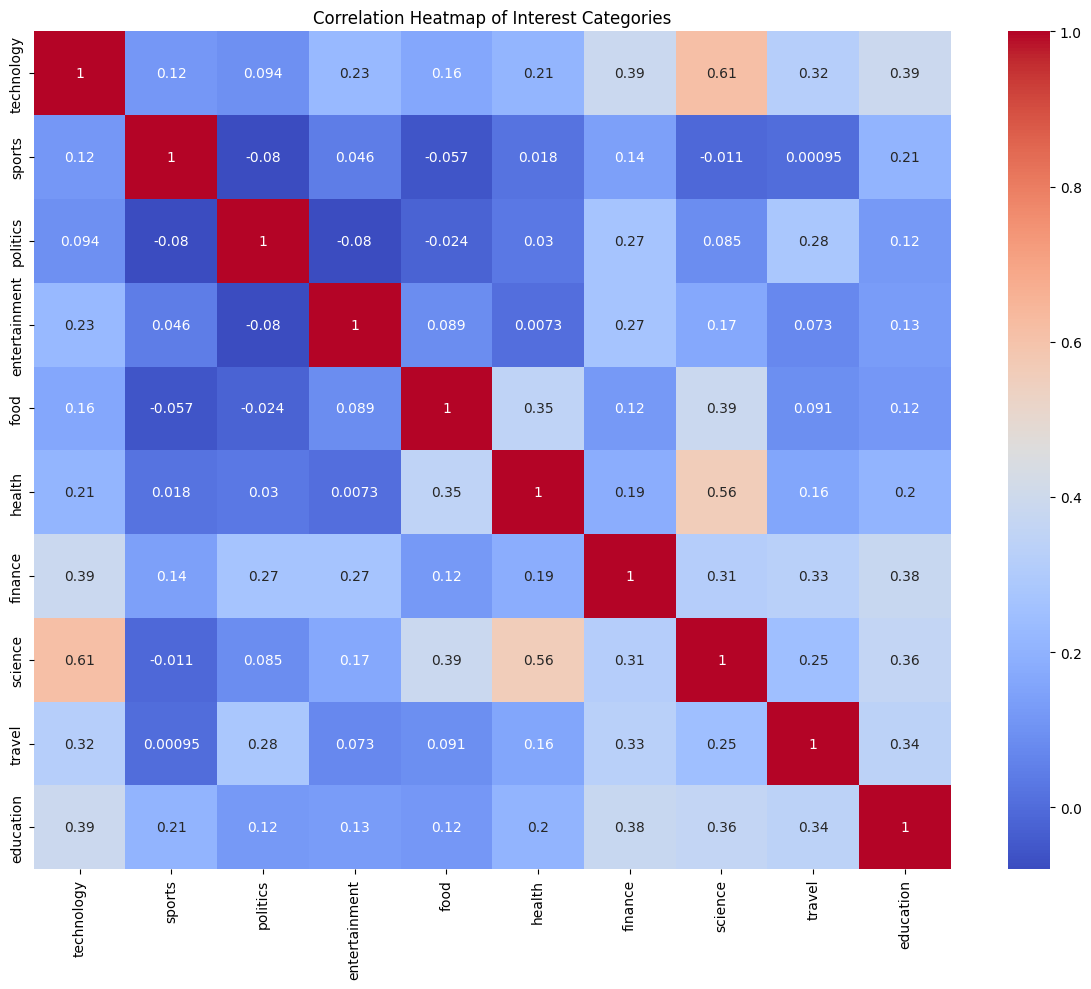

In [29]:
# 7. Correlation Heatmap of Interest Categories
interest_df = pd.DataFrame([tweet.interest_scores for tweet in tweets])
plt.figure(figsize=(12, 10))
sns.heatmap(interest_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Interest Categories")
plt.tight_layout()
plt.show()

In [31]:
# Create more users with different interest profiles
users = [
    User("user1", {
        "technology": 0.8, "sports": 0.3, "politics": 0.5, "entertainment": 0.7,
        "food": 0.4, "health": 0.6, "finance": 0.2, "science": 0.9,
        "travel": 0.5, "education": 0.6
    }),
    User("user2", {
        "technology": 0.3, "sports": 0.9, "politics": 0.2, "entertainment": 0.8,
        "food": 0.7, "health": 0.5, "finance": 0.1, "science": 0.4,
        "travel": 0.6, "education": 0.3
    }),
    User("user3", {
        "technology": 0.6, "sports": 0.4, "politics": 0.8, "entertainment": 0.5,
        "food": 0.3, "health": 0.7, "finance": 0.9, "science": 0.6,
        "travel": 0.2, "education": 0.5
    }),
    User("user4", {
        "technology": 0.7, "sports": 0.6, "politics": 0.4, "entertainment": 0.6,
        "food": 0.8, "health": 0.5, "finance": 0.3, "science": 0.7,
        "travel": 0.9, "education": 0.4
    })
]

In [32]:
from scipy.spatial.distance import cosine

def calculate_similarity(user1, user2):
    interests = list(user1.interests.keys())
    vector1 = np.array([user1.interests[interest] for interest in interests])
    vector2 = np.array([user2.interests[interest] for interest in interests])
    return 1 - cosine(vector1, vector2)

In [33]:
# Function to get friend recommendations for a user
def get_friend_recommendations(target_user, all_users):
    recommendations = []
    for user in all_users:
        if user != target_user:
            similarity = calculate_similarity(target_user, user)
            recommendations.append((user, similarity))
    return sorted(recommendations, key=lambda x: x[1], reverse=True)


In [34]:
# Get recommendations for the first user
target_user = users[0]
recommendations = get_friend_recommendations(target_user, users)

print(f"Friend recommendations for {target_user.username}:")
for user, similarity in recommendations:
    print(f"{user.username}: {similarity:.2%} similar")


Friend recommendations for user1:
user4: 92.68% similar
user3: 87.25% similar
user2: 81.95% similar


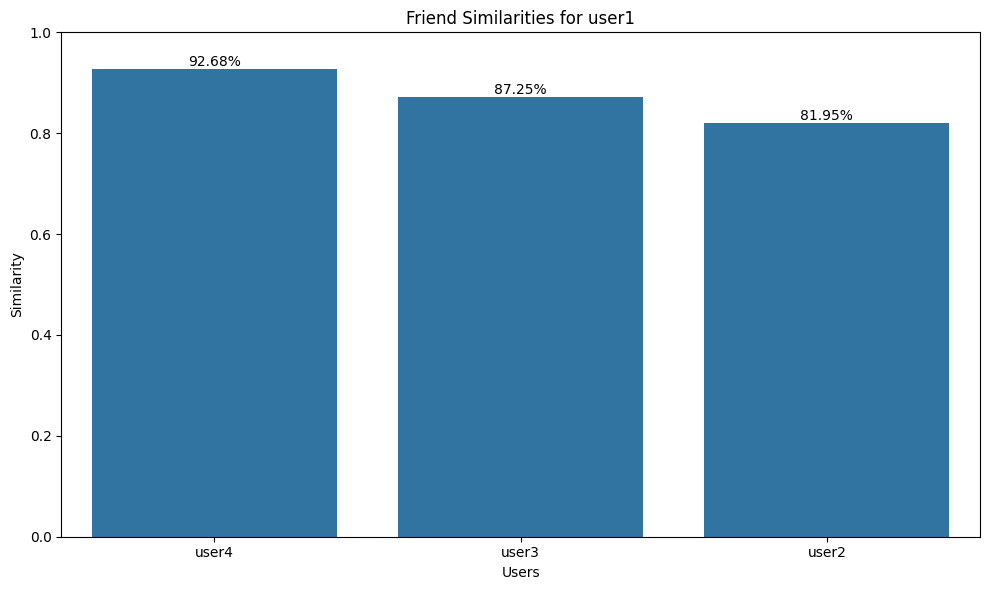

In [35]:
# Visualize the similarities
plt.figure(figsize=(10, 6))
usernames = [user.username for user, _ in recommendations]
similarities = [similarity for _, similarity in recommendations]
sns.barplot(x=usernames, y=similarities)
plt.title(f"Friend Similarities for {target_user.username}")
plt.xlabel("Users")
plt.ylabel("Similarity")
plt.ylim(0, 1)
for i, v in enumerate(similarities):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

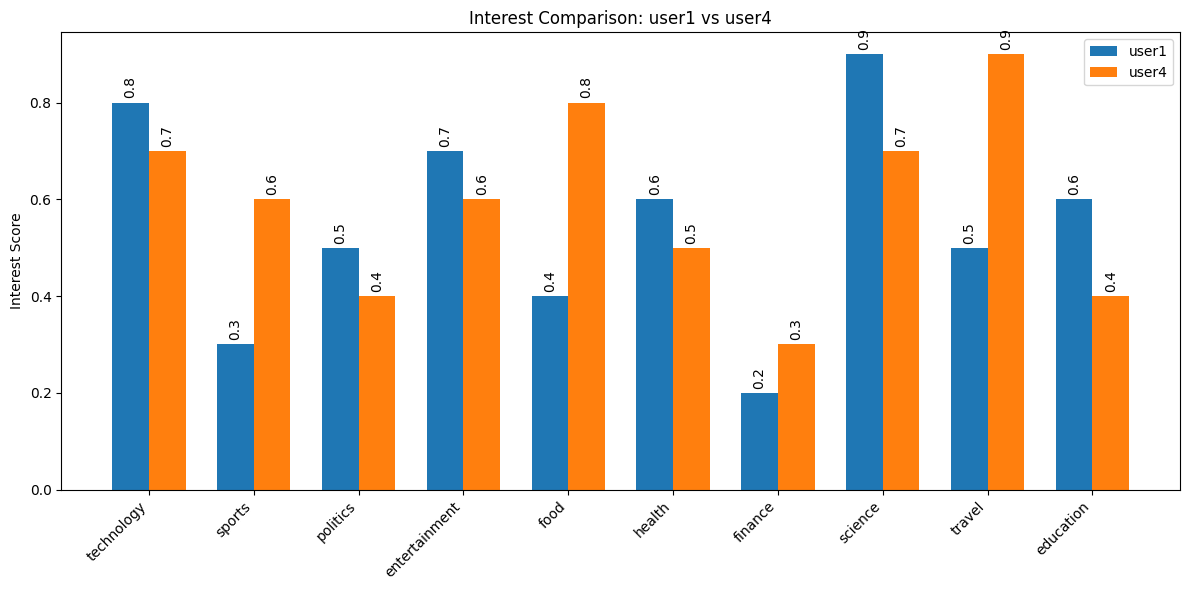

In [36]:
# Visualize interest comparison
def plot_interest_comparison(user1, user2):
    interests = list(user1.interests.keys())
    user1_scores = [user1.interests[interest] for interest in interests]
    user2_scores = [user2.interests[interest] for interest in interests]

    x = np.arange(len(interests))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, user1_scores, width, label=user1.username)
    rects2 = ax.bar(x + width/2, user2_scores, width, label=user2.username)

    ax.set_ylabel('Interest Score')
    ax.set_title(f'Interest Comparison: {user1.username} vs {user2.username}')
    ax.set_xticks(x)
    ax.set_xticklabels(interests, rotation=45, ha='right')
    ax.legend()

    ax.bar_label(rects1, padding=3, rotation=90)
    ax.bar_label(rects2, padding=3, rotation=90)

    fig.tight_layout()
    plt.show()

# Compare the target user with the most similar recommended user
plot_interest_comparison(target_user, recommendations[0][0])



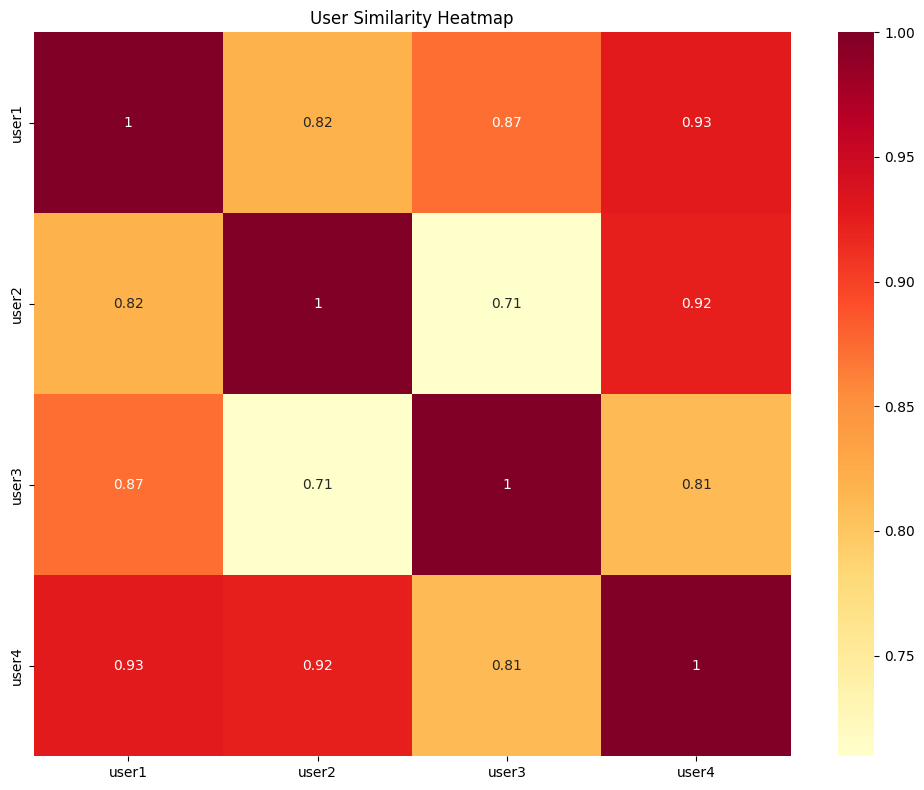

In [37]:
# Heatmap of similarities between all users
similarity_matrix = np.zeros((len(users), len(users)))
for i, user1 in enumerate(users):
    for j, user2 in enumerate(users):
        similarity_matrix[i, j] = calculate_similarity(user1, user2)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='YlOrRd', xticklabels=[user.username for user in users], yticklabels=[user.username for user in users])
plt.title("User Similarity Heatmap")
plt.tight_layout()
plt.show()